In [1]:
import data
import torch
import sde
import policy
import numpy as np
from torch.optim import SGD, RMSprop, Adagrad, AdamW, lr_scheduler, Adam
from torch.utils.tensorboard import SummaryWriter
from torch_ema import ExponentialMovingAverage
import matplotlib.pyplot as plt
import runner
from runner import Runner
import util



def build_optimizer_ema_sched(opt, policy):
    direction = policy.direction

    optim_name = {
        'Adam': Adam,
        'AdamW': AdamW,
        'Adagrad': Adagrad, 
        'RMSprop': RMSprop,
        'SGD': SGD,
    }.get(opt.optimizer)

    optim_dict = {
            "lr": opt.lr_f if direction=='forward' else opt.lr_b,
            'weight_decay':opt.l2_norm,
    }
    if opt.optimizer == 'SGD':
        optim_dict['momentum'] = 0.9

    optimizer = optim_name(policy.parameters(), **optim_dict)
    ema = ExponentialMovingAverage(policy.parameters(), decay=0.99)
    if opt.lr_gamma < 1.0:
        sched = lr_scheduler.StepLR(optimizer, step_size=opt.lr_step, gamma=opt.lr_gamma)
    else:
        sched = None

    return optimizer, ema, sched

class arg:
    samp_bs = 10
    # problem_name = 'Sin'#'Scurve'
    problem_name = 'Sin-Condi'#'Scurve'
    
    inner_itr = 2
    mask_update_itr = 1

    # condition = False # if False, it's exactly same with origin code
    condition = True # if False, it's exactly same with origin code


    channels=32
    nheads = 4
    mask_ratio = 0.5
    trans_layers = 4

    hidden_nodes = 128
    blocks = 2

    device = 'cuda:0'
    t0 = 0
    T=1
    interval=100
    sde_type = 've'
    noise_type = 'gaussian'
    sigma_min = 0.01
    sigma_max = 0.5
    forward_net = 'toy'
    backward_net = 'toy'
    

    optimizer = 'AdamW'
    lr = 1e-3
    lr_f = 1e-3
    lr_b = 1e-3
    lr_gamma = 0.8
    lr_step = 500
    l2_norm = 1e-3
    train_method = 'joint'
    seed = 123
    num_itr = 1000
    eval_itr = 1
    

    

opt = arg()
if opt.problem_name == 'Sin':
    opt.data_dim = [50]
elif opt.problem_name == 'Scurve':
    opt.data_dim = [2]   
elif opt.problem_name == 'Sin-Condi':
    opt.data_dim = [50]



     Likelihood-Training of Schrodinger Bridge
setting configurations...


In [2]:
with torch.cuda.device(opt.device):
    run = Runner(opt)
 
    run.sb_joint_train(opt)

build boundary distribution...
build base sde...
build forward policy...
number of parameters is 75557
build backward policy...
number of parameters is 75557
[SB joint] train_it 1/1000 | lr:1.00e-03 | loss:134.3600 | time:0:00:04.13
[SB joint] train_it 2/1000 | lr:1.00e-03 | loss:78.6922 | time:0:00:05.70
[SB joint] train_it 3/1000 | lr:1.00e-03 | loss:81.0990 | time:0:00:07.33
[SB joint] train_it 4/1000 | lr:1.00e-03 | loss:78.2836 | time:0:00:08.91
[SB joint] train_it 5/1000 | lr:1.00e-03 | loss:72.8453 | time:0:00:10.51
[SB joint] train_it 6/1000 | lr:1.00e-03 | loss:75.7890 | time:0:00:12.10
[SB joint] train_it 7/1000 | lr:1.00e-03 | loss:73.4490 | time:0:00:13.70
[SB joint] train_it 8/1000 | lr:1.00e-03 | loss:67.9960 | time:0:00:15.34
[SB joint] train_it 9/1000 | lr:1.00e-03 | loss:62.6055 | time:0:00:16.96
[SB joint] train_it 10/1000 | lr:1.00e-03 | loss:60.8803 | time:0:00:18.62
[SB joint] train_it 11/1000 | lr:1.00e-03 | loss:61.1684 | time:0:00:20.25
[SB joint] train_it 12/10

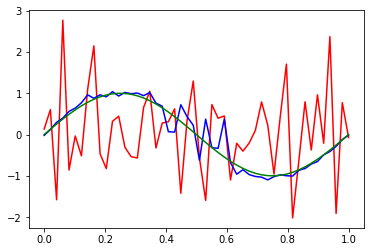

In [3]:

# raw test of the backward_network
with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b
    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)

xs_b_mean = xs_b.mean(0)
x = np.linspace(0,1,opt.data_dim[0])
plt.plot(x,xs_b[0,99,:].cpu(),'red') 
plt.plot(x,xs_b[0,0,:].cpu(),'blue')
plt.plot(x,np.sin(x*2*np.pi),'green')

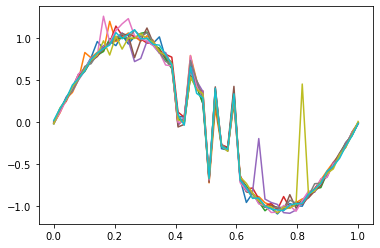

In [4]:

for i in range(opt.samp_bs):
    plt.plot(np.linspace(0,1,opt.data_dim[0]),xs_b[i,0,:].cpu())

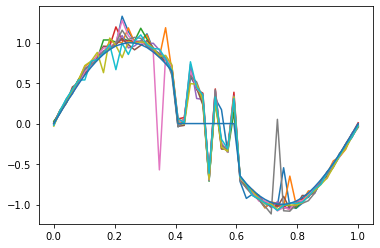

In [5]:
with torch.no_grad(): 
    x_condi_test = np.multiply(run.p.data,run.p.mask_obs)
    x_condi_test = torch.Tensor(x_condi_test.reshape(1,-1)).repeat(run.p.batch_size,1).to(opt.device)
    x_condi_test = x_condi_test.unsqueeze(1).repeat(1,opt.interval,1)
    x_condi_repeat = util.flatten_dim01(x_condi_test)
    policy_b.net.set_x_condi(x_condi_repeat)

    ts      = run.ts
    policy_b = run.z_b
    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)

for i in range(opt.samp_bs):
    plt.plot(np.linspace(0,1,opt.data_dim[0]),xs_b[i,0,:].cpu())
plt.plot(np.linspace(0,1,opt.data_dim[0]),x_condi_test[0,0,:].cpu())


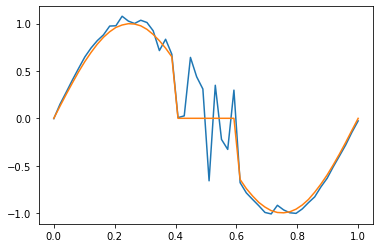

In [6]:
plt.plot(np.linspace(0,1,opt.data_dim[0]),xs_b[:,0,:].cpu().mean(0))
plt.plot(np.linspace(0,1,opt.data_dim[0]),x_condi_test[0,0,:].cpu())

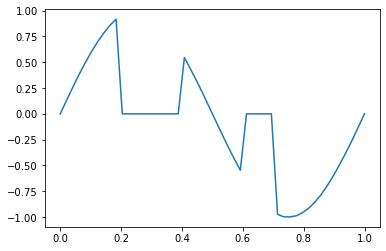

In [8]:
plt.plot(np.linspace(0,1,opt.data_dim[0]),x_condi_test[0,0,:].cpu())

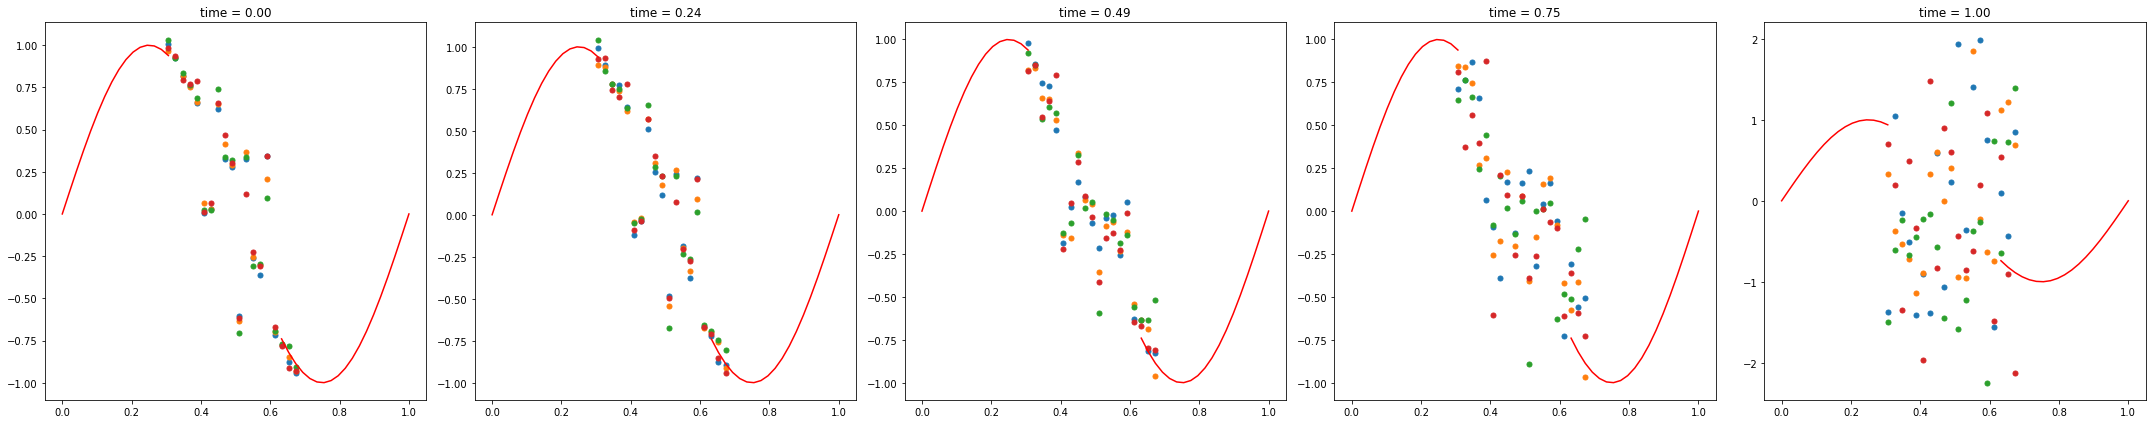

In [8]:

# for 1-d sin visulization
with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b
    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)
direction='backward'
traj = xs_b
n_snapshot = 5
lims = [-2.6, 2.6]

total_steps = opt.interval#traj.shape[1]
sample_steps = np.linspace(0, total_steps-1, n_snapshot).astype(int)
fig, axs = plt.subplots(1, n_snapshot)
fig.set_size_inches(n_snapshot*6, 6)
color = 'salmon' if direction=='forward' else 'royalblue'

x = np.linspace(0,1,opt.data_dim[0])

index_test = np.nonzero(run.p.mask_test)
index_train = np.nonzero(run.p.mask_obs)

index_train1 = np.concatenate([np.arange(0,16)])
index_train2 = np.concatenate([np.arange(31,50)])
index_test = np.concatenate([np.arange(15,34)])



for ax, step in zip(axs, sample_steps):

    # ax.scatter(traj[:,step,0],traj[:,step,1], s=5, color=color)
    # ax.scatter(x,traj[0,step,:], s=5, color=color)
    # ax.scatter(x[index_test],traj[0,step,index_test].squeeze())

    # ax.plot(x[index_test],traj[:,step,index_test].mean(0).squeeze())

    ax.scatter(x[index_test],traj[0,step,index_test].squeeze(),s=25)
    ax.scatter(x[index_test],traj[1,step,index_test].squeeze(),s=25)
    ax.scatter(x[index_test],traj[2,step,index_test].squeeze(),s=25)
    ax.scatter(x[index_test],traj[3,step,index_test].squeeze(),s=25)

    # ax.plot(x[index_test],traj[0,step,index_test].squeeze())
    # ax.plot(x[index_test],traj[1,step,index_test].squeeze())
    # ax.plot(x[index_test],traj[2,step,index_test].squeeze())
    # ax.plot(x[index_test],traj[3,step,index_test].squeeze())




    ax.plot(x[index_train1],np.sin(x[index_train1]*2*np.pi),'red')
    ax.plot(x[index_train2],np.sin(x[index_train2]*2*np.pi),'red')



    # ax.set_xlim(*lims)
    # ax.set_ylim(*lims)
    ax.set_title('time = {:.2f}'.format(step/(total_steps-1)*opt.T))
fig.tight_layout()

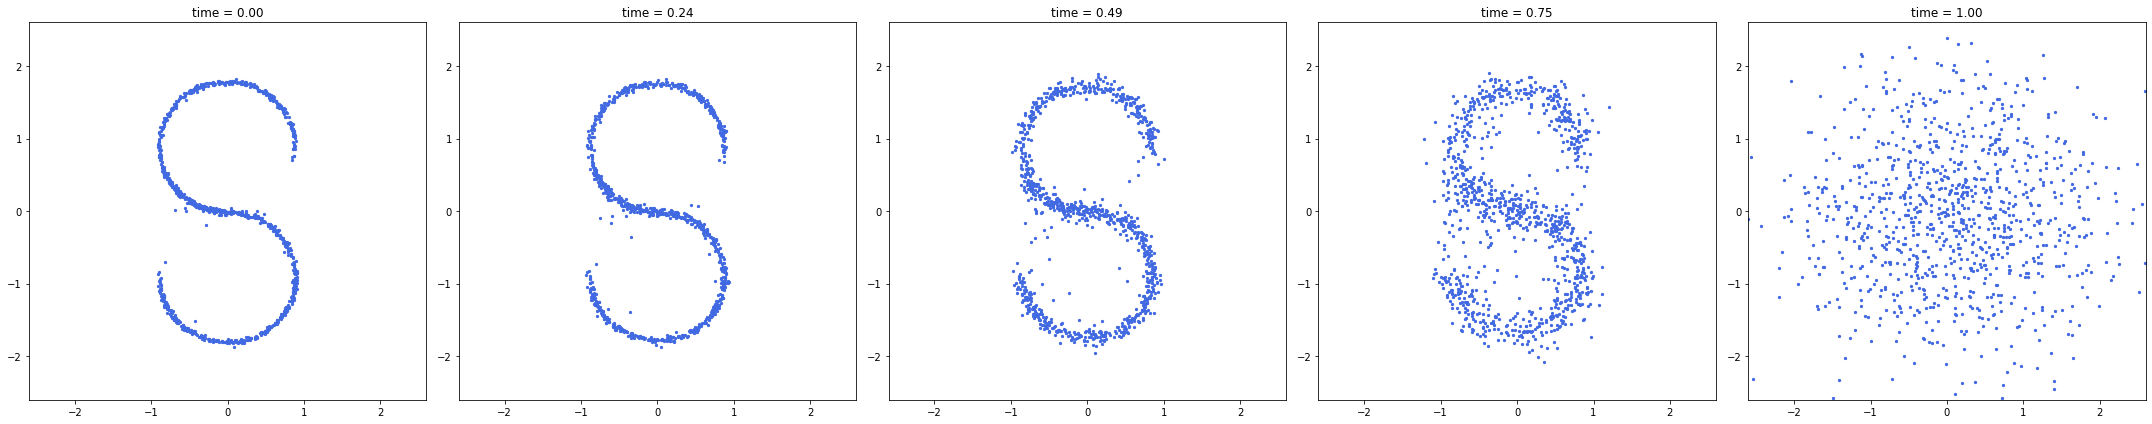

In [7]:
# for S-scurve visulization
with torch.no_grad():
    ts      = run.ts
    policy_b = run.z_b
    xs_b, _, _ =run.dyn.sample_traj(ts, policy_b, save_traj=True)
direction='backward'
traj = xs_b
n_snapshot = 5
lims = [-2.6, 2.6]

total_steps = traj.shape[1]
sample_steps = np.linspace(0, total_steps-1, n_snapshot).astype(int)
fig, axs = plt.subplots(1, n_snapshot)
fig.set_size_inches(n_snapshot*6, 6)
color = 'salmon' if direction=='forward' else 'royalblue'


for ax, step in zip(axs, sample_steps):

    ax.scatter(traj[:,step,0],traj[:,step,1], s=5, color=color)

    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
    ax.set_title('time = {:.2f}'.format(step/(total_steps-1)*opt.T))
fig.tight_layout()